Вторая лаба

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import pickle

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

In [4]:
df = pd.read_pickle('../data/clean_data.pkl').sample(frac=1, random_state = 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 99 to 169
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       302 non-null    int8    
 1   sex       302 non-null    category
 2   cp        302 non-null    category
 3   trestbps  302 non-null    int16   
 4   chol      302 non-null    int16   
 5   fbs       302 non-null    category
 6   restecg   302 non-null    category
 7   thalach   302 non-null    int16   
 8   exang     302 non-null    category
 9   oldpeak   302 non-null    float16 
 10  slope     302 non-null    category
 11  ca        302 non-null    category
 12  thal      302 non-null    category
 13  target    302 non-null    category
dtypes: category(9), float16(1), int16(3), int8(1)
memory usage: 7.9 KB


In [6]:
dict(df.iloc[0:1,:])

{'age': 99    53
 Name: age, dtype: int8,
 'sex': 99    1
 Name: sex, dtype: category
 Categories (2, int64): [0, 1],
 'cp': 99    2
 Name: cp, dtype: category
 Categories (4, int64): [0, 1, 2, 3],
 'trestbps': 99    130
 Name: trestbps, dtype: int16,
 'chol': 99    246
 Name: chol, dtype: int16,
 'fbs': 99    1
 Name: fbs, dtype: category
 Categories (2, int64): [0, 1],
 'restecg': 99    0
 Name: restecg, dtype: category
 Categories (3, int64): [0, 1, 2],
 'thalach': 99    173
 Name: thalach, dtype: int16,
 'exang': 99    0
 Name: exang, dtype: category
 Categories (2, int64): [0, 1],
 'oldpeak': 99    0.0
 Name: oldpeak, dtype: float16,
 'slope': 99    2
 Name: slope, dtype: category
 Categories (3, int64): [0, 1, 2],
 'ca': 99    3
 Name: ca, dtype: category
 Categories (5, int64): [0, 1, 2, 3, 4],
 'thal': 99    2
 Name: thal, dtype: category
 Categories (4, int64): [0, 1, 2, 3],
 'target': 99    1
 Name: target, dtype: category
 Categories (2, int64): [0, 1]}

In [7]:
cat_features = df.select_dtypes(include=['category']).columns.to_list()
num_features = df.select_dtypes(include=['number']).columns.to_list()
cat_features

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [9]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [10]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

На шаге transform для числовых признаков использовать StandardScaler, для категориальных - TargetEncoder(для задачи классификации)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import TargetEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

In [12]:
s_scaler = StandardScaler()
l_encoder = TargetEncoder() 
classifier= RandomForestClassifier()

In [13]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [14]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat', TargetEncoder(),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('model', RandomForestClassifier())])

Метрики качетсва для задачи классификации: precision, recall, f1, roc_auc

Precision = tp / (tp + fp), [наихудшее - 0, наилучшее - 1]

Recall = tp / (tp + fn), [наихудшее - 0, наилучшее - 1]

F1 = 2*tp / (2*tp + fp + fn)

Roc_auc = площадь под кривой ROC 

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

predictions = pipeline.predict(X_test) 

metrics = {}
metrics["precision"] = precision_score(y_test, predictions)   
metrics["recall"] = recall_score(y_test, predictions)
metrics["f1"] = f1_score(y_test, predictions)
metrics["roc_auc"] = roc_auc_score(y_test, predictions)

metrics

{'precision': 0.8478260869565217,
 'recall': 0.9069767441860465,
 'f1': 0.8764044943820225,
 'roc_auc': 0.8474277660324171}

In [16]:
confusion_matrix(y_test, predictions)

array([[26,  7],
       [ 4, 39]])

In [17]:
import mlflow

In [18]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)  

In [19]:
EXPERIMENT_NAME = "heart_project"
RUN_NAME = "baseline model2"
REGISTRY_MODEL_NAME = "heart_model_rf"

In [20]:
from mlflow.models import infer_signature
input_example = X_train.head(5)
signature =  infer_signature(model_input = X_train.head(5))

/home/mainuser/lab_IIS/.venv_IIS/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [21]:
req_file = 'requirements.txt'
art = 'comment.txt'

In [22]:
params_dict = pipeline.get_params()

логирование выдавало ошибку, т.к. не находил файл 'requirements.txt', поэтому я перенесла его в директорию 'research', файл 'comment.txt'создала в этой же папке 'research'

In [23]:
# Когда создаем новый эксперимент, то: 
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name = RUN_NAME, experiment_id=3) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

/home/mainuser/lab_IIS/.venv_IIS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/12/17 16:25:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model2 at: http://127.0.0.1:5000/#/experiments/3/runs/140d4b44baa04214be7348d4f0a1e76d.
2024/12/17 16:25:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3.


# Удаление экспериментов или прогонов

Удалить можно или эксперимент целиком, или один запуск (run) из него, для этого нужно определить их ID:

1) Эту информацию можно получить в Overview (обзор) нажав ЛКП по названию Run. Из таблицы нужны следующие данные:

- Experiment ID = 2

- Run ID = e3faad28c00a4e1cac5a10af2f15e070 

Затем используя 

`mlflow.delete_experiment(2)`

или

`mlflow.delete_run('e3faad28c00a4e1cac5a10af2f15e070 ')`

удаляете необходимое вам.

2) ID эксперимета и run можно узнать с помощью команд:

- `experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id`

- `mlflow.search_runs(experiment_names=[EXPERIMENT_NAME])`

во втором случае результатом выполнения команды будет таблица с данными всего эксперимента, где будет написаны усе ID всех run. Дальнейшее удаление выполняется командами из пункта 1.

Произведем различные трансформации наших данных, для генерации новых признаков. 

In [25]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [36]:
# создадим копию исходной обучающей выборки
X_train_copy = X_train.copy()

In [37]:
# используем PolynomialFeatures для 2-3 числовых признаков.
pf = PolynomialFeatures(degree=2)
pf.fit_transform(X_train_copy[['trestbps','oldpeak']])

array([[1.0000000e+00, 1.3000000e+02, 1.2001953e+00, 1.6900000e+04,
        1.5602539e+02, 1.4404688e+00],
       [1.0000000e+00, 1.2000000e+02, 7.9980469e-01, 1.4400000e+04,
        9.5976562e+01, 6.3968754e-01],
       [1.0000000e+00, 1.7000000e+02, 1.9995117e-01, 2.8900000e+04,
        3.3991699e+01, 3.9980471e-02],
       ...,
       [1.0000000e+00, 1.6000000e+02, 6.1992188e+00, 2.5600000e+04,
        9.9187500e+02, 3.8430313e+01],
       [1.0000000e+00, 1.2600000e+02, 0.0000000e+00, 1.5876000e+04,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.3000000e+02, 3.9990234e-01, 1.6900000e+04,
        5.1987305e+01, 1.5992188e-01]], dtype=float32)

In [38]:
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=3000), cat_features),
        ('poly', pf_pipeline, ['trestbps', 'oldpeak'])
    ],
    remainder='drop',
)

In [39]:
X_train_copy[['trestbps', 'oldpeak']] = X_train_copy[['trestbps', 'oldpeak']].astype('float64')

In [40]:
X_train_copy_raw = preprocessor_sklearn.fit_transform(X_train_copy)
X_train_copy = pd.DataFrame(X_train_copy_raw, columns=preprocessor_sklearn.get_feature_names_out())

In [41]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_copy)

,num__age,num__trestbps,num__chol,num__thalach,num__oldpeak,cat__sex,cat__cp,cat__fbs,cat__restecg,cat__exang,cat__slope,cat__ca,cat__thal,poly__1,poly__trestbps,poly__oldpeak,poly__trestbps^2,poly__trestbps oldpeak,poly__oldpeak^2
0,-0.432713,-0.133723,1.218765,-0.330034,0.149136,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,-0.133723,0.149136,-0.191340,0.087421,-0.201280
1,-1.458517,-0.681211,-0.134702,1.999433,-0.201017,1.0,2.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,-0.681211,-0.201017,-0.682142,-0.269455,-0.375104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,-1.572495,-0.352718,1.239588,0.610712,-0.900470,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,-0.352718,-0.900470,-0.392372,-0.839853,-0.513960
225,-1.230560,-0.133723,-0.280460,1.327471,-0.550744,1.0,2.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,-0.133723,-0.550744,-0.191340,-0.530887,-0.479246


In [46]:
column_names = X_train_copy.columns.tolist()
print(column_names)

['num__age', 'num__trestbps', 'num__chol', 'num__thalach', 'num__oldpeak', 'cat__sex', 'cat__cp', 'cat__fbs', 'cat__restecg', 'cat__exang', 'cat__slope', 'cat__ca', 'cat__thal', 'poly__1', 'poly__trestbps', 'poly__oldpeak', 'poly__trestbps^2', 'poly__trestbps oldpeak', 'poly__oldpeak^2']


In [47]:
with open('columns.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')

In [48]:
pipeline_sklearn = Pipeline(steps=[('preprocessor', preprocessor_sklearn), 
                           ('model', classifier)])

In [49]:
pipeline_sklearn.fit(X_train, y_train)

predictions = pipeline_sklearn.predict(X_test) 
metrics = {}
metrics["recall"] = recall_score(y_test, predictions)   
metrics["precision"] = precision_score(y_test, predictions)
metrics["f1"] = f1_score(y_test, predictions)
metrics["roc_auc"] = roc_auc_score(y_test, predictions)
metrics

{'recall': 0.8372093023255814,
 'precision': 0.8571428571428571,
 'f1': 0.8470588235294118,
 'roc_auc': 0.8276955602536997}

In [50]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'PF'
params_dict = pipeline_sklearn.get_params()

input_example = X_train_copy.head(5)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('columns.txt')
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


2024/11/24 15:25:00 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__age",
      "num__trestbps",
      "num__chol",
      "num__thalach",
      "num__oldpeak",
      "cat__sex",
      "cat__cp",
      "cat__fbs",
      "cat__restecg",
      "cat__exang",
      "cat__slope",
      "cat__ca",
      "cat__thal",
      "poly__1",
      "poly__trestbps",
      "poly__oldpeak",
      "poly__trestbps^2",
      "poly__trestbps oldpeak",
      "poly__oldpeak^2"
    ],
    "data": [
      [
        -0.4327134707839194,
        -0.13372286070907632,
        1.2187654871966387,
        -0.3300342189910607,
        0.14913647381118036,
        0.0,
        0.0,
        0.0,
        1.0,
        1.0,
        1.0,
        0.0,
        3.0,
        0.0,
        -0.13372286070907627,
        0.1491364738111804,
        -0.1913397877733708,
        0.08742124165091077,
        -0.2012795665954277
      ],
      [
        -1.4585

Отобререм N наиболее важных признаков. N выбирается с учетом количества признаков на предыдущем шаге, ориентировочный диапазон - от 20% до 70%.

In [52]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [53]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=100), 
                                k_features="best",
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='roc_auc',
                                cv=3)

In [54]:
sfs.fit(X_train_copy,y_train)

SequentialFeatureSelector(cv=3, estimator=RandomForestClassifier(),
                          k_features=(1, 19), scoring='roc_auc')

In [56]:
selected_features_sfs = X_train_copy.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__age,cat__sex,cat__cp,cat__fbs,cat__exang,cat__slope,cat__ca,cat__thal,poly__1,poly__oldpeak^2
0,-0.432713,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,-0.201280
1,-1.458517,1.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,-0.375104
2,0.479112,1.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,-0.505282
3,0.821046,0.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,-0.201280
4,-0.090779,1.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,1.188808
...,...,...,...,...,...,...,...,...,...,...
221,0.251155,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,-0.435790
222,0.251155,1.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,-0.479246
223,0.821046,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,7.828057
224,-1.572495,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,-0.513960


In [58]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx

[0, 5, 6, 7, 9, 10, 11, 12, 13, 18]

In [59]:
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['num__age',
 'cat__sex',
 'cat__cp',
 'cat__fbs',
 'cat__exang',
 'cat__slope',
 'cat__ca',
 'cat__thal',
 'poly__1',
 'poly__oldpeak^2']

In [60]:
with open('index.txt', 'w') as f:
    for i in rfe_sfs_idx:
        f.write(str(i) + '\n')

with open('columns_new.txt', 'w') as f:
    for i in rfe_sfs_col:
        f.write(i + '\n')

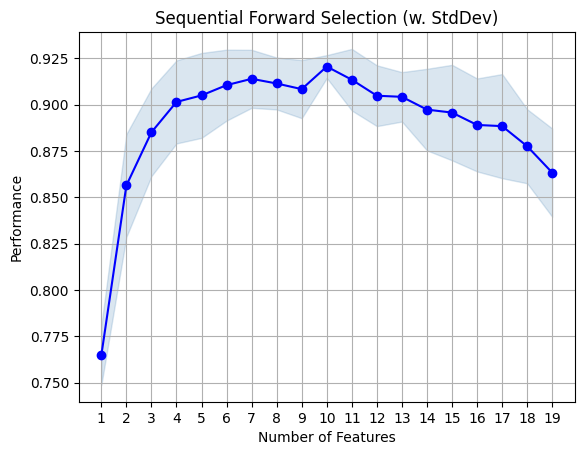

In [61]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()

In [62]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [63]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', classifier)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=3000),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['trestbps', 'oldpeak'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000026F2CB215E0>),
                ('model', RandomForestClassifier())])

In [64]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test) 
metrics = {}
metrics["recall"] = recall_score(y_test, predictions)   
metrics["precision"] = precision_score(y_test, predictions)
metrics["f1"] = f1_score(y_test, predictions)
metrics["roc_auc"] = roc_auc_score(y_test, predictions)
metrics

{'recall': 0.8372093023255814,
 'precision': 0.8571428571428571,
 'f1': 0.8470588235294118,
 'roc_auc': 0.8276955602536997}

In [65]:
signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)
params_dict = rfe_sfs_pipeline.get_params()
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('index.txt')
    mlflow.log_artifact('columns_new.txt')
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

c:\Users\79172\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/11/24 15:38:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_sfs_feature_selection at: http://127.0.0.1:5000/#/experiments/3/runs/88e593f21f96456ea6f7874863c193fe.
2024/11/24 15:38:33 INFO mlflo

С помощью optuna настроить оптимальные параметры для модели, показывающей лучший результат. Обучить модель, залогировать ее, зарегистрировать очередную версию.

У Random Forest будем настраивать параметры:

- количество деревьев
- глубина дерева
- max_features в интервале от 0.1 до 1.0

In [66]:
import optuna

c:\Users\79172\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [126]:
def objective(trial):
    # Предлагаем гиперпараметры
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 10, 200)
    max_features = trial.suggest_float('max_features', 0.1, 1)
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn),
        ('model', RandomForestClassifier(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       max_features=max_features, 
                                       random_state=43))
    ])
    opt_pipeline.fit(X_train, y_train)
    preds = opt_pipeline.predict(X_test)
    score = f1_score(y_test, preds, average='weighted')
    return score


In [127]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2024-11-24 16:02:51,630] A new study created in memory with name: no-name-e68471a8-2aeb-4065-8ab9-0490c3adbba1
[I 2024-11-24 16:02:51,808] Trial 0 finished with value: 0.8286146400483968 and parameters: {'n_estimators': 74, 'max_depth': 190, 'max_features': 0.6559998942510546}. Best is trial 0 with value: 0.8286146400483968.
[I 2024-11-24 16:02:52,016] Trial 1 finished with value: 0.8678603468899521 and parameters: {'n_estimators': 111, 'max_depth': 173, 'max_features': 0.5448579082538428}. Best is trial 1 with value: 0.8678603468899521.
[I 2024-11-24 16:02:52,169] Trial 2 finished with value: 0.868421052631579 and parameters: {'n_estimators': 89, 'max_depth': 67, 'max_features': 0.1845806137444768}. Best is trial 2 with value: 0.868421052631579.
[I 2024-11-24 16:02:52,456] Trial 3 finished with value: 0.868421052631579 and parameters: {'n_estimators': 190, 'max_depth': 141, 'max_features': 0.42765202052414575}. Best is trial 2 with value: 0.868421052631579.
[I 2024-11-24 16:02:52,5

Number of finished trials: 30
Best trial: {'n_estimators': 115, 'max_depth': 115, 'max_features': 0.35393600475059334}


In [128]:
best_params = study.best_trial.params
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', RandomForestClassifier(**best_params))
])

opt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=3000),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['trestbps', 'oldpeak'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000026F31B08650>),
                ('model',
                 RandomForestClassifier(max_depth=115,
                                        max_features=0.35393600475059334,
                                        n_estimators=115))])

In [129]:
predictions = opt_pipeline.predict(X_test)

metrics = {}
metrics["recall"] = recall_score(y_test, predictions)   
metrics["precision"] = precision_score(y_test, predictions)
metrics["f1"] = f1_score(y_test, predictions)
metrics["roc_auc"] = roc_auc_score(y_test, predictions)
metrics

{'recall': 0.9069767441860465,
 'precision': 0.9069767441860465,
 'f1': 0.9069767441860465,
 'roc_auc': 0.8928823114869625}

In [130]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna_model2'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(opt_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/24 16:03:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model2 at: http://127.0.0.1:5000/#/experiments/3/runs/613d533e342240cf9020aa120ddfe717.
2024/11/24 16:03:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3.


Обучить эту модель на всей выборке (а не только на train-части), залогировать ее. В реестре моделей установить ей тэг Production.

In [134]:
X = df.drop('target', axis=1)
y = df['target']

In [135]:
opt_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=3000),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['trestbps', 'oldpeak'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x0000026F31B08650>),
                ('model',
                 RandomForestClassifier(max_depth=115,
                                        max_features=0.35393600475059334,
                                        n_estimators=115))])

In [136]:

with open('columns_for_training_final_model.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')

signature =  infer_signature(model_input = X.head(5))
input_example = X.head(5)
params_dict = opt_pipeline.get_params()

with mlflow.start_run(run_name='final_model', experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             )
    mlflow.log_artifact('../requirements.txt')
    mlflow.log_artifact('columns_for_training_final_model.txt')
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

c:\Users\79172\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/11/24 16:17:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/3/runs/631930cba3004003a5b966dc1e642aec.
2024/11/24 16:17:26 INFO mlflow.tracking._tr